## <font color='313187'>Notebook Index<font><a class='anchor' id='top'></a>    
## - [Libraries](#Libraries)
## - [Data understanding](#Data_understanding)
### - [Test dataset](#TestDataset)
### - [Board dataset](#BoardDataset)
### - [Check categorical variables categories and their distributions](#categVars)
### - [Data preprocessing and cleaning](#cleaning)
#### - [Select products to forecast](#SelectProducts)
#### - [Check duplicates](#duplictaes)
#### - [Check missing values](#missing)
#### - [Plot at product - reporter level](#plotProdReport)
#### - [Impute missing values with interpolation](#ImputeMissing)
#### - [Plot imputed values at product - reporter level](#plotImputedMissing)
#### - [Outliers detection and imputation](#Outliers)
#### - [Aggregate data at forecast level product](#AggregateData)
#### - [Plot at product level](#PLotProductLevel)
### - [Checking seasonality](#seasonality)
### - [Save data](#SaveProcessed)
## - [Modelling approach](#ModellingApproach)
### - [Backtesting](#backtesting)
#### - [Forecasting with Seasonal Naïve and Moving average models](#naiveMA)
#### - [Forecasting with Autoarima](#Autoarima)
#### - [Backtesting results for individual models](#backtestingResults)
#### - [Forecasting with Best model](#bestmodels)
#### - [Backtesting Plots](#backtestingPlots)
### - [Get future forecast](#futureForecast)
#### - [Future forecast with Seasonal Naïve and MA models](#futureFcstNaiveMA)
#### - [Future forecast with AutoArima](#futureFctsAutoarimia)
#### - [Future forecast with Best Model](#futureFctsBestModel)
#### - [Future forecast plots](#futureFctsPlots)
#### - [Kaggle Score for best model](#kaggle)
## - [Future work](#futureWork)

## <font color='313187'>Libraries<font><a class='anchor' id='Libraries'></a> [↑](#top)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages
import time
import math
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import warnings
from math import sqrt
import copy

In [2]:
#!pip install pmdarima

In [3]:
# Only for report porposes
warnings.filterwarnings("ignore")

In [4]:
# The following code sets display options for pandas to show all rows and columns,
# and prevent wrapping of long lines in the output.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [5]:
# Define path
path = "C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP"

In [13]:
# Define variables in config
TEST_SIZE = 13

## <font color='313187'>Data understanding<font><a class='anchor' id='Data_understanding'></a> [↑](#top)

### <font color='313187'>Test dataset<font><a class='anchor' id='TestDataset'></a> [↑](#top)

In [5]:
# Read file
test_df = pd.read_csv(path + "/data/raw/test.csv", sep=',')

In [6]:
test_df.head()

,id
0,202319-105609
1,202319-107583
2,202319-10857
3,202319-109557
4,202319-112518


In [7]:
# Split the string into two columns
test_df[['year_week', 'product_number']] = test_df['id'].str.split('-', expand=True)

In [8]:
test_df.head()

,id,year_week,product_number
0,202319-105609,202319,105609
1,202319-107583,202319,107583
2,202319-10857,202319,10857
3,202319-109557,202319,109557
4,202319-112518,202319,112518


In [9]:
# Get number of unique values for each variable
test_df.nunique(axis=0)

id                1300
year_week           13
product_number     100
dtype: int64

In [10]:
# Check missing
test_df.isnull().sum()

id                0
year_week         0
product_number    0
dtype: int64

In [11]:
# Check first and last weeks to forecast 
print('First forecast date:', test_df.year_week.min(), '\nLast  forecast date:', test_df.year_week.max())

First forecast date: 202319 
Last  forecast date: 202331


We want to forecast 13 weeks for 100 products.

### <font color='313187'>Board dataset<font><a class='anchor' id='BoardDataset'></a> [↑](#top)

In [12]:
# Read file
board = pd.read_csv(path + "/data/raw/train_v2.csv", sep=',')

In [13]:
board.head()

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units
0,202224-2961,2022-06-18,202224,2961,15,Doraemon,186631,15.6,Gaming,52.0,88.0
1,202225-2961,2022-06-25,202225,2961,15,Doraemon,186631,15.6,Gaming,6.0,88.0
2,202226-2961,2022-07-02,202226,2961,15,Doraemon,186631,15.6,Gaming,60.0,138.0
3,202227-2961,2022-07-09,202227,2961,15,Doraemon,186631,15.6,Gaming,158.0,65.0
4,202228-2961,2022-07-16,202228,2961,15,Doraemon,186631,15.6,Gaming,23.0,30.0


In [14]:
# Print data type of each column
board.dtypes

id                  object
date                object
year_week            int64
product_number       int64
reporterhq_id        int64
prod_category       object
specs                int64
display_size       float64
segment             object
sales_units        float64
inventory_units    float64
dtype: object

In [15]:
# Convert dates to datetime
board["date"] = pd.to_datetime(board["date"], format='%Y/%m/%d')

In [16]:
# Print data type of each column
board.dtypes

id                         object
date               datetime64[ns]
year_week                   int64
product_number              int64
reporterhq_id               int64
prod_category              object
specs                       int64
display_size              float64
segment                    object
sales_units               float64
inventory_units           float64
dtype: object

In [17]:
# Check data structure
board.shape 

(25139, 11)

In [18]:
board.head()

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units
0,202224-2961,2022-06-18,202224,2961,15,Doraemon,186631,15.6,Gaming,52.0,88.0
1,202225-2961,2022-06-25,202225,2961,15,Doraemon,186631,15.6,Gaming,6.0,88.0
2,202226-2961,2022-07-02,202226,2961,15,Doraemon,186631,15.6,Gaming,60.0,138.0
3,202227-2961,2022-07-09,202227,2961,15,Doraemon,186631,15.6,Gaming,158.0,65.0
4,202228-2961,2022-07-16,202228,2961,15,Doraemon,186631,15.6,Gaming,23.0,30.0


In [19]:
# Get number of unique values for each variable
board.nunique(axis=0)

id                 15381
date                 213
year_week            213
product_number       233
reporterhq_id         20
prod_category          7
specs                233
display_size           9
segment                3
sales_units          175
inventory_units      396
dtype: int64

- We have information about products we don't want to forecast (As the test set only has 100 products)
- Each product has each own specifications (the specification id is unique for each product).
- The data is at weekly level as all days in dates are saturdays.
- The data is at weekly, product, reporter level, we will need to aggregate the data at week- product level.

### <font color='313187'>Check categorical variables categories and their distributions<font><a class='anchor' id='categVars'></a> [↑](#top)

In [20]:
# Get unique values by each categorical variable and their frequency.
cols = ['prod_category', 'display_size', 'segment']

# Loop over each column
for col in cols:
        print(f"Unique values in column '{col}':")
        print(board[col].value_counts())
        print()

Unique values in column 'prod_category':
Clover      7115
Goku        5424
Arale       4078
Doraemon    3455
Luffy       2044
Conan       2043
Bobobo       980
Name: prod_category, dtype: int64

Unique values in column 'display_size':
15.6    9793
17.3    4485
14.0    4417
13.3    3206
16.1    1926
13.5     876
11.0     292
11.6      97
12.0      47
Name: display_size, dtype: int64

Unique values in column 'segment':
Core       12682
Premium     6242
Gaming      6215
Name: segment, dtype: int64



### <font color='313187'>Data preprocessing and cleaning<font><a class='anchor' id='cleaning'></a> [↑](#top)

#### <font color='313187'>Select products to forecast<font><a class='anchor' id='SelectProducts'></a> [↑](#top)

In [22]:
test_df.head()

,id,year_week,product_number
0,202319-105609,202319,105609
1,202319-107583,202319,107583
2,202319-10857,202319,10857
3,202319-109557,202319,109557
4,202319-112518,202319,112518


In [23]:
# Keep only the products we want to forecast
forecast_products = test_df['product_number'].unique()
print('Number of products in test: ' + str(len(forecast_products)))

board = board[board['product_number'].isin(forecast_products.astype(int))]
number_products = len(board['product_number'].unique())
print('Number of products in board: ' + str(number_products))
print('Number of rows in board: ' + str(board.shape[0]))

Number of products in test: 100
Number of products in board: 100
Number of rows in board: 15262


In [24]:
# Get Number of vendors by product
number_product_vendor = len(board[['product_number','reporterhq_id']].drop_duplicates())
print('Number of product-vendors in board: ' + str(number_product_vendor))
vendors_per_product = board.groupby('product_number')['reporterhq_id'].nunique()
print('Mean of vendors per product: ' + str(np.mean(vendors_per_product)))

Number of product-vendors in board: 295
Mean of vendors per product: 2.95


#### <font color='313187'>Check duplicates<font><a class='anchor' id='duplictaes'></a> [↑](#top)

In [25]:
# Check for duplicates in the 'id' and 'reporterhq_id' columns
duplicates = board.duplicated(subset=['id', 'reporterhq_id'])

# Get the rows where duplicates are present
duplicate_rows = board[duplicates]

# Check if any duplicates exist
if duplicate_rows.empty:
    print("No duplicates found in the 'id' and 'reporterhq_id' columns.")
else:
    print("Duplicates found in the 'id' and 'reporterhq_id' columns:")
    print(duplicate_rows)

No duplicates found in the 'id' and 'reporterhq_id' columns.


Now we will explore the missing values and dates before aggregating at year_week - product level

#### <font color='313187'>Check missing values<font><a class='anchor' id='missing'></a> [↑](#top)

In [26]:
## Check missing values
board.isnull().sum()

id                   0
date                 0
year_week            0
product_number       0
reporterhq_id        0
prod_category        0
specs                0
display_size         0
segment              0
sales_units        287
inventory_units    301
dtype: int64

We will assume they are missings and not 0's as there are 0's present in the table.

#### <font color='313187'>Check missing dates<font><a class='anchor' id='missingDates'></a> [↑](#top)

In [27]:
# Check if all dates in 'date' column are Saturdays
all_saturdays = (board['date'].dt.dayofweek == 5).all()

# Print the result
if all_saturdays:
    print("All dates in the 'date' column are Saturdays.")
else:
    print("Not all dates in the 'date' column are Saturdays.")


All dates in the 'date' column are Saturdays.


In [28]:
### Check if the time series are compleate
# Convert to string
board['year_week'] = board['year_week'].astype(str)
board['reporterhq_id'] = board['reporterhq_id'].astype(str)

# Group the board DataFrame by product_number and reporterhq_id
grouped_data = board.groupby(['product_number', 'reporterhq_id'])

# Initialize an empty DataFrame to store missing dates
missing_dates = pd.DataFrame(columns=['product_number', 'reporterhq_id', 'missing_date'])

# Iterate over each group (product - reporterhq_id)
for group_key, group in grouped_data:
    product, reporter = group_key
    
    # Get the minimum and maximum date for the product - reporterhq_id
    min_date = group['date'].min()
    max_date = group['date'].max()
    
    # Generate the expected date range for the product
    expected_dates = pd.date_range(start=min_date, end=max_date, freq='W-SAT')
    
    # Check for missing dates
    missing = expected_dates[~expected_dates.isin(group['date'])]
    
    # Add the missing dates to the missing_dates DataFrame
    for missing_date in missing:
        missing_dates = missing_dates.append({'product_number': product, 
                                              'reporterhq_id': reporter,
                                              'missing_date': missing_date}, ignore_index=True)

In [29]:
# Print the % of products or product-reporter (=vendor) with missnig values and the number of rows with missing values
num_products_with_missing = len(missing_dates['product_number'].unique())
print('Number of products with missing dates: ' + 
      str(num_products_with_missing) + ' ' +  str(int((num_products_with_missing/number_products)*100)) + '%')

num_products_vendors_with_missing = len(missing_dates[['product_number','reporterhq_id']].drop_duplicates())
print('Number of product-vendor with missing dates: ' +
      str(num_products_vendors_with_missing) + ' ' + str(int((num_products_vendors_with_missing/number_product_vendor)*100)) + '%')
     
print('Number of rows with missing dates: ' + str(len(missing_dates)))
print('')
print(missing_dates.head())

Number of products with missing dates: 81 81%
Number of product-vendor with missing dates: 157 53%
Number of rows with missing dates: 1741

  product_number reporterhq_id missing_date
0           6909            93   2021-11-13
1           6909            93   2022-05-07
2           6909            93   2022-06-04
3           6909            93   2022-07-09
4           6909            93   2022-07-16


In [30]:
## Prepare the  missing dates table to be able to add it later into the board
missing_dates = missing_dates.rename(columns={'missing_date': 'date'})
missing_dates = missing_dates.merge(board[['date', 'year_week']].drop_duplicates(), on='date', how='left')
missing_dates['sales_units'] = np.nan
missing_dates['inventory_units'] = np.nan
missing_dates['id'] = missing_dates['year_week'] + '-' + missing_dates['product_number'].astype(str)
missing_dates = missing_dates.merge(board[['product_number', 'prod_category', 'specs', 'display_size', 'segment']].drop_duplicates(), on='product_number', how='left')
missing_dates = missing_dates.astype({"product_number": int, "specs": int})
missing_dates.head()

,product_number,reporterhq_id,date,year_week,sales_units,inventory_units,id,prod_category,specs,display_size,segment
0,6909,93,2021-11-13,202145,NaN,NaN,202145-6909,Arale,21274,13.3,Premium
1,6909,93,2022-05-07,202218,NaN,NaN,202218-6909,Arale,21274,13.3,Premium
2,6909,93,2022-06-04,202222,NaN,NaN,202222-6909,Arale,21274,13.3,Premium
3,6909,93,2022-07-09,202227,NaN,NaN,202227-6909,Arale,21274,13.3,Premium
4,6909,93,2022-07-16,202228,NaN,NaN,202228-6909,Arale,21274,13.3,Premium


In [31]:
# Check number of rows in board considering the missing values before concatenating
missing_dates.shape[0] + board.shape[0]

17003

In [32]:
# Add the missing dates to the board
full_board = pd.concat([board, missing_dates], ignore_index=True)
full_board.shape[0]

17003

In [33]:
# Get columns indicating where we have missings in sales and inventory
full_board['is_missing_sales_units'] = full_board['sales_units'].isnull()
full_board['is_missing_inventory_units'] = full_board['inventory_units'].isnull()

In [34]:
# Fill NA with 0
full_board['sales_units'] = full_board['sales_units'].fillna(0)
full_board['inventory_units'] = full_board['inventory_units'].fillna(0)

In [37]:
# Count missing values
missing_by_product = full_board.groupby('product_number')['is_missing_sales_units', 'is_missing_inventory_units'].sum()
missing_by_product = full_board.groupby('product_number')['is_missing_sales_units', 'is_missing_inventory_units'].sum()
total_rows_by_product = full_board.groupby('product_number').size().reset_index(name='length')
missing_by_product =  missing_by_product.merge(total_rows_by_product, on = 'product_number', how ='left')
missing_by_product['percentage_missing_by_product_sales_units'] =  (missing_by_product['is_missing_sales_units'] / missing_by_product['length'])*100
missing_by_product['percentage_missing_by_product_inventory_units'] =  (missing_by_product['is_missing_inventory_units'] / missing_by_product['length'])*100

missing_by_product['percentage_missing_by_product_sales_units'] = missing_by_product['percentage_missing_by_product_sales_units'].round().astype(int)
missing_by_product['percentage_missing_by_product_inventory_units'] = missing_by_product['percentage_missing_by_product_inventory_units'].round().astype(int)

In [38]:
# Sort by % of missings
missing_by_product = missing_by_product.sort_values('percentage_missing_by_product_inventory_units', ascending = False)
missing_by_product.head()

,product_number,is_missing_sales_units,is_missing_inventory_units,length,percentage_missing_by_product_sales_units,percentage_missing_by_product_inventory_units
89,231945,111,111,207,54,54
93,236880,115,117,246,47,48
54,148050,69,68,162,43,42
47,116466,54,53,131,41,40
19,48363,57,61,182,31,34


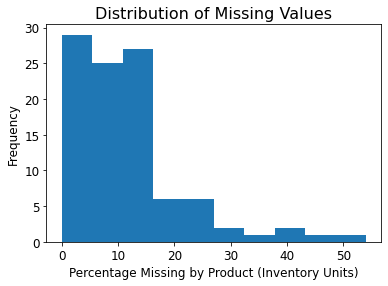

In [39]:
### Check distribution of missings

# Create a histogram
plt.hist(missing_by_product['percentage_missing_by_product_inventory_units'], bins=10)

# Set the labels and title
plt.xlabel('Percentage Missing by Product (Inventory Units)',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Distribution of Missing Values', fontsize=16)

# Increase the size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the histogram
plt.show()

#### <font color='313187'>Plot at product - reporter level<font><a class='anchor' id='plotProdReport'></a> [↑](#top)

In [40]:
# Reorder table by date and reporter
full_board = full_board.sort_values(['product_number','reporterhq_id','date'])

In [41]:
# Set the number of subplots per PDF file
subplots_per_file = 30

# Get unique product numbers and reporterhq_ids
product_reporters = full_board[['product_number', 'reporterhq_id']].drop_duplicates()

# Calculate the number of PDF files required
num_files = int(np.ceil(product_reporters.shape[0] / subplots_per_file))
print(num_files)

10


Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_missings_0.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_missings_1.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_missings_2.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_missings_3.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_missings_4.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_missings_5.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_missings_6.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_missings_7.pdf
Plots saved to C:/Users/Laura/OneDrive/D

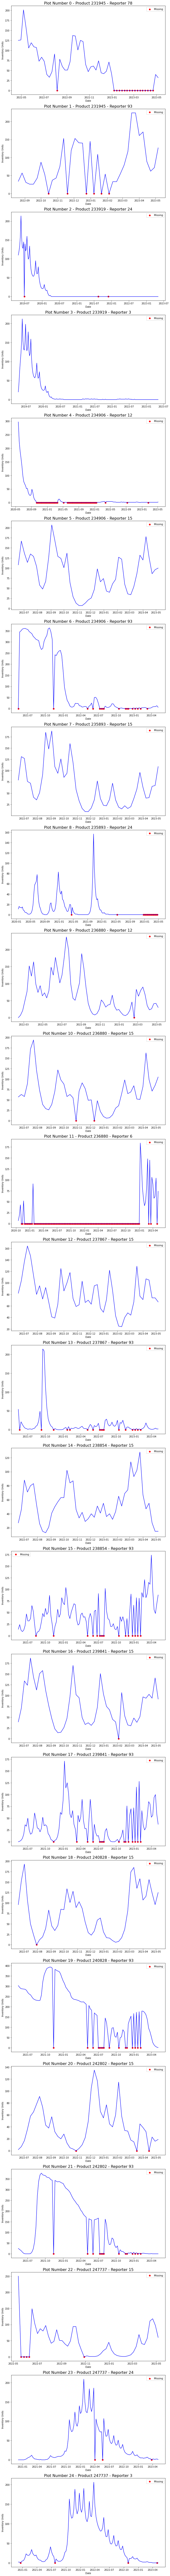

In [244]:
### Print series at product - reporter level with missing values
column_name = 'inventory_units'

# Iterate over the number of PDF files
for file_index in range(num_files):

    # Close the current figure
    plt.close(fig)
    plt.close('all')

    pdf_file = '/plots/inventory_missings_' + str(file_index) +'.pdf'
    pdf_path = path + pdf_file
    pdf_path
    
    start_index = file_index * subplots_per_file
    end_index = (file_index + 1) * subplots_per_file


    # Get the corresponding subset of product_reporters
    product_reporters_subset = product_reporters[start_index:end_index]
    product_numbers = product_reporters_subset['product_number'].unique()

    
    # Set up the figure and subplots
    fig, axes = plt.subplots(product_reporters_subset.shape[0], 1, figsize=(10, 6 * product_reporters_subset.shape[0]), sharex=False)

    index = 0 
    # Iterate over product numbers
    for i, product in enumerate(product_numbers):

        # Filter reporterhq_ids for the current product
        reporterhq_ids = product_reporters_subset[product_reporters['product_number'] == product]['reporterhq_id'].unique()

        # Iterate over reporterhq_ids
        for j, reporter in enumerate(reporterhq_ids):

            # Filter data for the current product and reporterhq_id
            product_data = full_board[(full_board['product_number'] == product) & (full_board['reporterhq_id'] == reporter)]

            # Determine the subplot index
            subplot_index = index

            # Plot the time series
            axes[subplot_index].plot(product_data['date'], product_data[column_name], color='blue')

            # Filter missing points for the current product and reporterhq_id
            missing_data = product_data[product_data['is_missing_inventory_units']]

            # Plot the missing points as red markers
            axes[subplot_index].scatter(missing_data['date'], missing_data[column_name], color='red', label='Missing')

            # Set title and labels for each subplot
            axes[subplot_index].set_title(f'Plot Number {subplot_index} - Product {product} - Reporter {reporter}', fontsize=16)
            axes[subplot_index].set_ylabel('Inventory Units')
            axes[subplot_index].set_xlabel('Date')
            axes[subplot_index].legend()

            # Increase the size of the tick labels
            ax[rowindex, colindex].tick_params(axis='x', labelsize=12)
            ax[rowindex, colindex].tick_params(axis='y', labelsize=12)
            
            index = index + 1
    # Adjust the layout and spacing
    plt.tight_layout()

    # Save the plots to a PDF file
    with PdfPages(pdf_path) as pdf:
        pdf.savefig(fig)

    print(f"Plots saved to {pdf_path}")

    # Pause the execution for 3 seconds
    time.sleep(3)

#### <font color='313187'>Impute missing values with interpolation<font><a class='anchor' id='ImputeMissing'></a> [↑](#top)

In [42]:
### Imput missing values
# Create inventory_units_imputed_missing and sales_units_imputed_missing columns
full_board['inventory_units_imputed_missing'] = full_board['inventory_units']
full_board['sales_units_imputed_missing'] = full_board['sales_units']

# Impute missing values in inventory_units and sales_units column
full_board.loc[full_board['is_missing_inventory_units'], 'inventory_units_imputed_missing'] = np.nan
full_board.loc[full_board['is_missing_sales_units'], 'sales_units_imputed_missing'] = np.nan

In [43]:
# Sort the data by date and reporter in ascending order
full_board = full_board.sort_values(['product_number','reporterhq_id','date'])
full_board.head()

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units,is_missing_sales_units,is_missing_inventory_units,inventory_units_imputed_missing,sales_units_imputed_missing
54,202224-6909,2022-06-18,202224,6909,15,Arale,21274,13.3,Premium,0.0,16.0,False,False,16.0,0.0
56,202225-6909,2022-06-25,202225,6909,15,Arale,21274,13.3,Premium,2.0,29.0,False,False,29.0,2.0
58,202226-6909,2022-07-02,202226,6909,15,Arale,21274,13.3,Premium,85.0,59.0,False,False,59.0,85.0
60,202227-6909,2022-07-09,202227,6909,15,Arale,21274,13.3,Premium,48.0,29.0,False,False,29.0,48.0
61,202228-6909,2022-07-16,202228,6909,15,Arale,21274,13.3,Premium,0.0,17.0,True,False,17.0,NaN


In [44]:
### Impute inventory_units
# Group the data by product_number and reporterhq_id
groups = full_board.groupby(['product_number', 'reporterhq_id'])

# Define a function to perform interpolation within each group
def interpolate_group(group):
    group['inventory_units_imputed_missing'] = group['inventory_units_imputed_missing'].interpolate()
    return group

# Apply the interpolation function to each group
full_board_imputed = groups.apply(interpolate_group)


In [45]:
### Impute sales_units
# Group the data by product_number and reporterhq_id
groups = full_board_imputed.groupby(['product_number', 'reporterhq_id'])

# Define a function to perform interpolation within each group
def interpolate_group(group):
    group['sales_units_imputed_missing'] = group['sales_units_imputed_missing'].interpolate()
    return group

# Apply the interpolation function to each group
full_board_imputed = groups.apply(interpolate_group)

In [46]:
full_board_imputed.head()

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units,is_missing_sales_units,is_missing_inventory_units,inventory_units_imputed_missing,sales_units_imputed_missing
54,202224-6909,2022-06-18,202224,6909,15,Arale,21274,13.3,Premium,0.0,16.0,False,False,16.0,0.0
56,202225-6909,2022-06-25,202225,6909,15,Arale,21274,13.3,Premium,2.0,29.0,False,False,29.0,2.0
58,202226-6909,2022-07-02,202226,6909,15,Arale,21274,13.3,Premium,85.0,59.0,False,False,59.0,85.0
60,202227-6909,2022-07-09,202227,6909,15,Arale,21274,13.3,Premium,48.0,29.0,False,False,29.0,48.0
61,202228-6909,2022-07-16,202228,6909,15,Arale,21274,13.3,Premium,0.0,17.0,True,False,17.0,24.0


In [47]:
# Get statistics of the imputed values in the inventory_units
statistics = full_board_imputed.loc[full_board_imputed['is_missing_inventory_units'], 'inventory_units_imputed_missing'].describe()
statistics

count    2034.000000
mean       73.690757
std        58.145619
min         0.000000
25%        31.016667
50%        63.225000
75%       101.725000
max       399.500000
Name: inventory_units_imputed_missing, dtype: float64

In [48]:
# Get statistics of the imputed values in the sales_units
statistics = full_board_imputed.loc[full_board_imputed['is_missing_sales_units'], 'sales_units_imputed_missing'].describe()
statistics

count    2020.000000
mean       23.061386
std        26.924745
min         0.000000
25%         3.794444
50%        14.500000
75%        31.744048
max       188.702703
Name: sales_units_imputed_missing, dtype: float64

#### <font color='313187'>Plot imputed values at product - reporter level<font><a class='anchor' id='plotImputedMissing'></a> [↑](#top)

In [49]:
# Set the number of subplots per PDF file
subplots_per_file = 30

# Get unique product numbers and reporterhq_ids
product_reporters = full_board[['product_number', 'reporterhq_id']].drop_duplicates()

# Calculate the number of PDF files required
num_files = int(np.ceil(product_reporters.shape[0] / subplots_per_file))
print(num_files)

10


Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_imputed_missings_0.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_imputed_missings_1.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_imputed_missings_2.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_imputed_missings_3.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_imputed_missings_4.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_imputed_missings_5.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_imputed_missings_6.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory

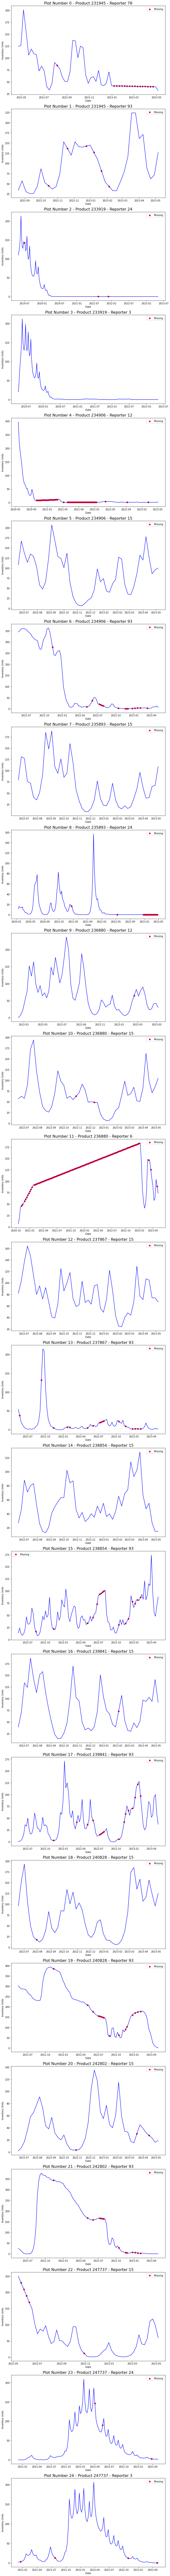

In [253]:
### Print series at product - reporter level with missing values imputed
column_name = 'inventory_units_imputed_missing'

# Iterate over the number of PDF files
for file_index in range(num_files):

    # Close the current figure
    plt.close(fig)
    plt.close('all')

    pdf_file = '/plots/inventory_imputed_missings_' + str(file_index) +'.pdf'
    pdf_path = path + pdf_file
    pdf_path
    
    start_index = file_index * subplots_per_file
    end_index = (file_index + 1) * subplots_per_file
 

    # Get the corresponding subset of product_reporters
    product_reporters_subset = product_reporters[start_index:end_index]
    product_numbers = product_reporters_subset['product_number'].unique()

    
    
    # Set up the figure and subplots
    fig, axes = plt.subplots(product_reporters_subset.shape[0], 1, figsize=(10, 6 * product_reporters_subset.shape[0]), sharex=False)

    index = 0 
    # Iterate over product numbers
    for i, product in enumerate(product_numbers):

        # Filter reporterhq_ids for the current product
        reporterhq_ids = product_reporters_subset[product_reporters['product_number'] == product]['reporterhq_id'].unique()

        # Iterate over reporterhq_ids
        for j, reporter in enumerate(reporterhq_ids):

            # Filter data for the current product and reporterhq_id
            product_data = full_board_imputed[(full_board_imputed['product_number'] == product) & (full_board_imputed['reporterhq_id'] == reporter)]

            # Determine the subplot index
            subplot_index = index

            # Plot the time series
            axes[subplot_index].plot(product_data['date'], product_data[column_name], color='blue')

            # Filter missing points for the current product and reporterhq_id
            missing_data = product_data[product_data['is_missing_inventory_units']]

            # Plot the missing points as red markers
            axes[subplot_index].scatter(missing_data['date'], missing_data[column_name], color='red', label='Missing')

            # Set title and labels for each subplot
            axes[subplot_index].set_title(f'Plot Number {subplot_index} - Product {product} - Reporter {reporter}', fontsize=16)
            axes[subplot_index].set_ylabel('Inventory Units')
            axes[subplot_index].set_xlabel('Date')
            axes[subplot_index].legend()

            # Increase the size of the tick labels
            ax[rowindex, colindex].tick_params(axis='x', labelsize=12)
            ax[rowindex, colindex].tick_params(axis='y', labelsize=12)
            
            index = index + 1
    # Adjust the layout and spacing
    plt.tight_layout()

    # Save the plots to a PDF file
    with PdfPages(pdf_path) as pdf:
        pdf.savefig(fig)

    print(f"Plots saved to {pdf_path}")

    # Pause the execution for 3 seconds
    time.sleep(3)

The following product-reporters only has one date, which didn't allowed to add the missing dates. We will keep it like this as the products has other reporters with all the dates and its better in this case to aggregate only the data point instead of imputing all the rest of the values equal to this single one. 

In [329]:
full_board_imputed[(full_board_imputed['product_number'] == 195426) & 
                   (full_board_imputed['reporterhq_id'] == '39')]

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units,is_missing_sales_units,is_missing_inventory_units,inventory_units_imputed_missing,sales_units_imputed_missing
11361,202251-195426,2022-12-24,202251,195426,39,Clover,207905,15.6,Core,111.0,348.0,False,False,348.0,111.0


In [330]:
full_board_imputed[(full_board_imputed['product_number'] == 119427) & 
                   (full_board_imputed['reporterhq_id'] == '6')]

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units,is_missing_sales_units,is_missing_inventory_units,inventory_units_imputed_missing,sales_units_imputed_missing
7767,202301-119427,2023-01-07,202301,119427,6,Goku,139248,14.0,Core,0.0,0.0,True,False,0.0,NaN


### <font color='313187'>Outliers detection and imputation<font><a class='anchor' id='Outliers'></a> [↑](#top)

Outliers were not addressed in this project due to time constraints, but it is important to acknowledge their potential impact on the RMSE (Root Mean Square Error) metric. Outliers can introduce significant errors  and inflate the overall measure of accuracy.

#### <font color='313187'>Aggregate data at forecast level product<font><a class='anchor' id='AggregateData'></a> [↑](#top)

In [50]:
# Aggregate the data at year_week - product (id) level
aggregated_board = full_board_imputed.groupby('id').agg({
    'date': 'first',  
    'year_week': 'first',
    'product_number': 'first',
    'prod_category': 'first',
    'specs': 'first',
    'display_size': 'first',
    'segment': 'first',
    'sales_units': 'sum',
    'inventory_units': 'sum',
    'is_missing_inventory_units' : lambda x: x.any(),
    'is_missing_sales_units' : lambda x: x.any(),
    'inventory_units_imputed_missing' : 'sum',
    'sales_units_imputed_missing' : 'sum'
    
})

# Reset the index to make 'id' a column again
aggregated_board = aggregated_board.reset_index()

# Print the aggregated board fro check purposes 
#aggregated_board[(aggregated_board['product_number']==6909) & (aggregated_board['year_week']=='202228')  ].head()

#### <font color='313187'>Plot at product level<font><a class='anchor' id='PLotProductLevel'></a> [↑](#top)

In [51]:
# Set the number of subplots per PDF file
subplots_per_file = 30
num_products = aggregated_board['product_number'].drop_duplicates().shape[0]

# Calculate the number of PDF files required
num_files = math.ceil(num_products / subplots_per_file)
num_files
range(num_files)

range(0, 4)

Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_imputed_missings_product_level_0.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_imputed_missings_product_level_1.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_imputed_missings_product_level_2.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/inventory_imputed_missings_product_level_3.pdf


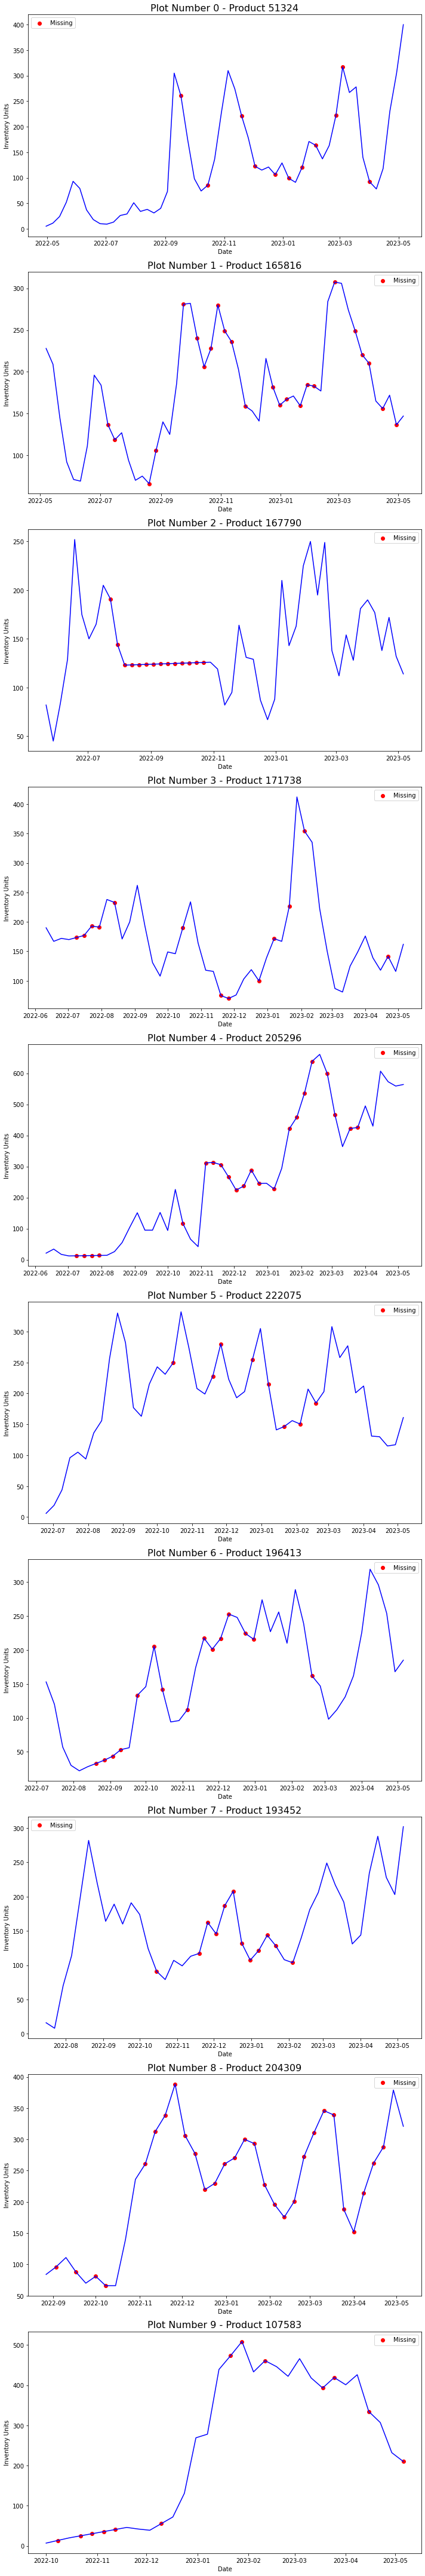

In [256]:
# Plot at product level
column_name = 'inventory_units_imputed_missing'
data = aggregated_board

# Iterate over the number of PDF files
for file_index in range(num_files):

    # Close the current figure
    plt.close(fig)
    plt.close('all')

    pdf_file = '/plots/inventory_imputed_missings_product_level_' + str(file_index) +'.pdf'
    pdf_path = path + pdf_file
    pdf_path
    
    # Get unique product numbers and reporterhq_ids
    product_reporters = data[['product_number']].drop_duplicates()

    start_index = file_index * subplots_per_file
    end_index = (file_index + 1) * subplots_per_file


    # Get the corresponding subset of product_reporters
    product_reporters_subset = product_reporters[start_index:end_index]
    product_numbers = product_reporters_subset['product_number'].unique()

    
    
    # Set up the figure and subplots
    fig, axes = plt.subplots(product_reporters_subset.shape[0], 1, figsize=(10, 6 * product_reporters_subset.shape[0]), sharex=False)

    index = 0 
    # Iterate over product numbers
    for i, product in enumerate(product_numbers):
        
        # Filter data for the current product and reporterhq_id
        product_data = data[(data['product_number'] == product)]

        # Determine the subplot index
        subplot_index = index

        # Plot the time series
        axes[subplot_index].plot(product_data['date'], product_data[column_name], color='blue')

        # Filter missing points for the current product and reporterhq_id
        missing_data = product_data[product_data['is_missing_inventory_units']]

        # Plot the missing points as red markers
        axes[subplot_index].scatter(missing_data['date'], missing_data[column_name], color='red', label='Missing')

        # Set title and labels for each subplot
        axes[subplot_index].set_title(f'Plot Number {subplot_index} - Product {product}', fontsize=16)
        axes[subplot_index].set_ylabel('Inventory Units')
        axes[subplot_index].set_xlabel('Date')
        axes[subplot_index].legend()

        # Increase the size of the tick labels
        ax[rowindex, colindex].tick_params(axis='x', labelsize=12)
        ax[rowindex, colindex].tick_params(axis='y', labelsize=12)
        
        index = index + 1
                            
    # Adjust the layout and spacing
    plt.tight_layout()

    # Save the plots to a PDF file
    with PdfPages(pdf_path) as pdf:
        pdf.savefig(fig)

    print(f"Plots saved to {pdf_path}")

    # Pause the execution for 3 seconds
    time.sleep(3)


### <font color='313187'>Check time series history length<font><a class='anchor' id='Summary'></a> [↑](#top)

In [52]:
# Caalculate history length for each product
aggregated_board['history_length'] = aggregated_board.groupby('product_number')['product_number'].transform('count')

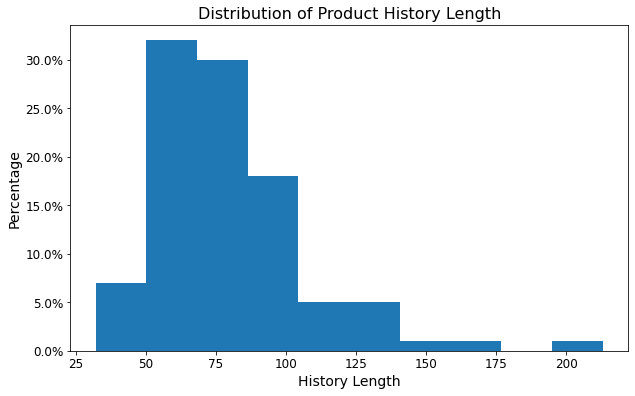

In [53]:
# Plot distribution of history length
product_history_length = aggregated_board.groupby('product_number')['history_length'].first().reset_index()

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram
counts, bins, _ = plt.hist(product_history_length['history_length'], bins=10)

# Calculate the total number of data points
total_data_points = len(product_history_length)

# Convert counts to percentages
percentages = (counts / total_data_points) * 100

# Set the labels and title
plt.xlabel('History Length', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.title('Distribution of Product History Length', fontsize=16)

# Set the y-axis tick labels as percentages
plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()])

# Increase the size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()


Only arround 7 products has between 30 and 50 data points. So the majority of products has enough data. 

In [54]:
# Get history length statistics
product_history_length.head()
statistics = product_history_length['history_length'].describe()
statistics

count    100.000000
mean      80.500000
std       27.982137
min       32.000000
25%       65.750000
50%       71.000000
75%       93.000000
max      213.000000
Name: history_length, dtype: float64

The product that has less data points has 32 weeks. 

### <font color='313187'>Checking seasonality with Augmented Dickey-Fuller test<font><a class='anchor' id='seasonality'></a> [↑](#top)

We will cluster products based on seasonality and apply distinct models to each cluster

In [55]:
# Define function to check if a product is seasonal or not with Augmented Dickey-Fuller (ADF) test
def check_seasonality(time_series):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(time_series)
    
    # Get the p-value from the test result
    p_value = result[1]
    
    # Set a significance level (e.g., 0.05)
    significance_level = 0.05
    
    # Check if the p-value is less than the significance level
    if p_value < significance_level:
        return True  # Time series is seasonal
    else:
        return False  # Time series is not seasonal


In [56]:
# Check seasonality for each product with Augmented Dickey-Fuller (ADF) test
# Iterate over each product
for product_number, product_data in aggregated_board.groupby('product_number'):
    # Extract the 'inventory_units_imputed_missing' time series for the current product
    time_series = product_data['inventory_units_imputed_missing']
    
    # Split the time series into training and testing sets
    train_time_series = time_series[:-TEST_SIZE]
    
    # Check if the training set time series is seasonal
    is_seasonal = check_seasonality(train_time_series)
    
    # Update the 'is_seasonal' column for the current product
    aggregated_board.loc[aggregated_board['product_number'] == product_number, 'is_seasonal'] = is_seasonal

In [57]:
# Get number of seasonal/no seasonal products 
is_seasonal = aggregated_board[['product_number', 'is_seasonal']].drop_duplicates()
is_seasonal['is_seasonal'].value_counts()

False    64
True     36
Name: is_seasonal, dtype: int64

### <font color='313187'>Save data<font><a class='anchor' id='SaveProcessed'></a> [↑](#top)

In [380]:
# Save datasets to a csv file
to_save = [board, full_board ,full_board_imputed, aggregated_board]
file_names = ['board.csv', 'full_board.csv', 'full_board_imputed.csv', 'aggregated_board.csv']

save_path = path + '/data/processed/'

for data, file_name in zip(to_save, file_names):
    file_path = save_path + file_name
    data.to_csv(file_path, index=False)

print("Datasets saved successfully!")

Datasets saved successfully!


## <font color='313187'>Modelling approach<font><a class='anchor' id='ModellingApproach'></a> [↑](#top)

- In order to forecast the next 13 weeks using a short-term approach, we will employ a rolling forecasting method. This approach involves making predictions one at a time and incorporating each prediction into the training set. By continuously updating the training data with recent observations, the model can adapt and capture any changes or trends that may occur during the forecast period.
- To assess the accuracy of our forecasts, we will set aside a dedicated test set comprising 13 weeks of data. This test set will align with the time period we aim to forecast, allowing us to evaluate the performance of our models in predicting the future in a 13-week period.

### <font color='313187'>Backtesting<font><a class='anchor' id='backtesting'></a> [↑](#top)

In [19]:
# Retrieve data and check we don't have any duplicates
df=pd.read_csv(path + '/data/processed/aggregated_board.csv')
duplicates = df.duplicated(subset=['date','product_number'])
duplicate_rows = df[duplicates]
print('Number of duplicates: ' + str(duplicate_rows.shape[0]))

Number of duplicates: 0


We will set the test set with 13 weeks (the same amount of weeks we will need to forecast) 

In [60]:
# Initialize actual results list
new_results_list = []

In [27]:
df.head()

,id,date,year_week,product_number,prod_category,specs,display_size,segment,sales_units,inventory_units,is_missing_inventory_units,is_missing_sales_units,inventory_units_imputed_missing,sales_units_imputed_missing,history_length,is_seasonal
0,201915-233919,2019-04-13,201915,233919,Clover,106370,15.6,Core,2.0,20.0,False,False,20.0,2.0,213,True
1,201916-233919,2019-04-20,201916,233919,Clover,106370,15.6,Core,4.0,43.0,False,False,43.0,4.0,213,True
2,201917-233919,2019-04-27,201917,233919,Clover,106370,15.6,Core,122.0,184.0,False,False,184.0,122.0,213,True
3,201918-233919,2019-05-04,201918,233919,Clover,106370,15.6,Core,61.0,219.0,False,False,219.0,61.0,213,True
4,201919-233919,2019-05-11,201919,233919,Clover,106370,15.6,Core,32.0,254.0,False,False,254.0,32.0,213,True


#### <font color='313187'>Forecasting with Seasonal Naïve and Moving average models (Baseline)<font><a class='anchor' id='naiveMA'></a> [↑](#top)

In [ ]:
### Backtesting with Seasonal Naïve and MA
#product_numbers = [43428] #Test purposes
#df = df[df['product_number'].isin(product_numbers)] #Test purposes
forcast_evolution = 1
total_num_prod = df['product_number'].drop_duplicates().shape[0]

# Iterate for each product
for product_number, product_data in df.groupby('product_number'):
    print('Forecasting product: ' + str(product_number) + '  '+ str(forcast_evolution) +'/'+str(total_num_prod))
    X = product_data['inventory_units_imputed_missing']
    size = len(X)-TEST_SIZE
    train, test = X[0:size], X[size:len(X)]
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
    history = [c for c in train]
    predictions = list()
    is_seasonal = product_data['is_seasonal'].iloc[0]
    
    # Iterate for each week (rolling approach)
    for t in range(TEST_SIZE):  # Forecast the next 13 weeks
        if is_seasonal:
            last_year_week_index = -52 

            if -last_year_week_index > len(train):
                # If there are no previous year observations available, apply MA
                window_size = TEST_SIZE  # Number of previous observations to include in the average
                y = np.mean(history[-window_size:])
            else:
                y = history[last_year_week_index]  # Use the previous year's observation for the same week
     
        else:
            window_size = TEST_SIZE  # Number of previous observations to include in the average
            y = np.mean(history[-window_size:])
        
        # Append predictions to predictions list and train set (history)
        predictions.append(y)
        history.append(y)
    
    forcast_evolution += 1
    
    # Prepare results table using pandas DataFrame
    product_results_df = pd.DataFrame({'product_number': product_number,
                                       'model_name': 'Naïve or MA',
                                       'is_seasonal': is_seasonal,
                                       'outliers_treatment': 0,
                                       'validation_approach': 'rolling',
                                       'actuals': test,
                                       'prediction': predictions})
    
    # Append the results for the current product to the overall results list
    new_results_list.append(product_results_df)

print('Forecast has finished')


#### <font color='313187'>Forecasting with Autoarima<font><a class='anchor' id='Autoarima'></a> [↑](#top)

In [65]:
## !!! Run only if you have saved results and the skip the next cell
# Retrieve saved results (kernel is running slow)
arima_results_df = pd.read_csv(path + '/backtesting_results/results_df.csv')
arima_results_df = arima_results_df[arima_results_df['test_name'] == 'AutoARIMA']

In [ ]:
### Backtesting with Seasonal AutoArima
#product_numbers = [32571, 6909, 233919, 234906] #Test purposes
#df = df[df['product_number'].isin(product_numbers)] #Test purposes
forcast_evolution = 1
total_num_prod = df['product_number'].drop_duplicates().shape[0]


# Iterate for each product
for product_number, product_data in df.groupby('product_number'):
    print('Forecasting product: ' + str(product_number) + '  '+ str(forcast_evolution) +'/'+str(total_num_prod))
    X = product_data['inventory_units_imputed_missing']
    size = len(X)-TEST_SIZE
    train, test = X[0:size], X[size:len(X)]
    history = [c for c in train]
    predictions = list()
    
    # Iterate for each week (rolling approach)
    for t in range(len(test)):
        if product_data['is_seasonal'].iloc[0]:
            model = auto_arima(X, 
                               start_p=1, start_q=1,
                               max_p=5, max_q=5, 
                               m=52, #52 for weekly data, 12 for monthly data
                               max_d=1, max_D=1,
                               start_P=0, start_Q=0, 
                               max_P=5, max_Q=5, 
                               seasonal=True,
                               trace=False,
                               error_action='ignore',
                               suppress_warnings=True, 
                               stepwise=True) # True to speed up the parameter selection
            is_seasonal = True
        else:
            model = auto_arima(X, start_p=1, start_q=1,
                               max_p=5, max_q=5, max_d=1,
                               trace=False, seasonal=False,
                               error_action='ignore',
                               suppress_warnings=True, 
                               stepwise=True) 
            is_seasonal = False
        
        # Fit the model and get forecast
        model_fit = model.fit(history)
        output = model_fit.predict(n_periods=1)
        yhat = output[0]
        
        # Append predictions to predictions list and train set (history)
        predictions.append(yhat)
        history.append(yhat)
    
    forcast_evolution += 1
    
    # Prepare results table using pandas DataFrame
    product_results_df = pd.DataFrame({'product_number': product_number,
                                       'model_name': 'AutoARIMA',
                                       'is_seasonal': is_seasonal,
                                       'outliers_treatment': 0,
                                       'validation_approach': 'rolling',
                                       'actuals': test,
                                       'prediction': predictions})
    
    # Append the results for the current product to the overall results list
    new_results_list.append(product_results_df)

    
print('Forecast has finished')

#### <font color='313187'>Backtesting results for individual models<font><a class='anchor' id='backtestingResults'></a> [↑](#top)

In [66]:
# Convert results list to DataFrame
results_df = pd.concat(new_results_list, ignore_index=True)
print(results_df.shape[0])

# Add name of the test as the individual models used for forecasting
results_df['test_name'] = results_df['model_name']

#results_df[(results_df['model_name'] == 'Naïve or MA') & (results_df['product_number'] == 6909)]

1300


In [71]:
### !!!!! Run only if retrieved arima results from saved results
# Concatenate the dataframes vertically
results_df = pd.concat([results_df, arima_results_df], axis=0)

# Reset the index of the combined dataframe
results_df = results_df.reset_index(drop=True)
#print(combined_df['model_name'].value_counts())

In [72]:
# Calculate Global RMSE (by test) 
grouped = results_df.groupby(['test_name'])

results = []
for group_name, group_df in grouped:
    actuals = group_df['actuals']
    predictions = group_df['prediction']
    rmse = round(sqrt(mean_squared_error(actuals, predictions)),2)
    mean_act = round(np.mean(actuals),2)
    if mean_act == 0:
        # Handle the case where the mean of actuals is zero
        relative_rmse = 'N/A'  # or assign a default value
    else:
        relative_rmse = round((rmse / mean_act) * 100, 2)
   
    results.append({'test_name': group_name,
                    'model_name': group_df['model_name'].iloc[0],
                    'outliers_treatment': group_df['outliers_treatment'].iloc[0],
                    'validation_approach': group_df['validation_approach'].iloc[0],
                    'RMSE': rmse,
                    'Mean_actuals':mean_act,
                    'Relative RMSE':relative_rmse})

global_results_df = pd.DataFrame(results)

# Print results
global_results_df

,test_name,model_name,outliers_treatment,validation_approach,RMSE,Mean_actuals,Relative RMSE
0,AutoARIMA,AutoARIMA,0,rolling,102.81,202.76,50.71
1,Naïve or MA,Naïve or MA,0,rolling,99.13,202.76,48.89


In [74]:
# Calculate RMSE by product
grouped = results_df.groupby(['test_name','product_number'])

results = []
for group_name, group_df in grouped:
    actuals = group_df['actuals']
    predictions = group_df['prediction']
    rmse = round(sqrt(mean_squared_error(actuals, predictions)),2)
    mean_act = round(np.mean(actuals),2)
    if mean_act == 0:
        # Handle the case where the mean of actuals is zero
        relative_rmse = 'N/A'  # or assign a default value
    else:
        relative_rmse = round((rmse / mean_act) * 100, 2)
    results.append({'test_name': group_name[0],
                    'product_number': group_name[1],
                    'model_name': group_df['model_name'].iloc[0],
                    'outliers_treatment': group_df['outliers_treatment'].iloc[0],
                    'validation_approach': group_df['validation_approach'].iloc[0],
                    'RMSE': rmse,
                    'Mean_actuals':mean_act,
                    'Relative RMSE':relative_rmse})

product_results_df = pd.DataFrame(results)

# Print results
product_results_df.head(4)

,test_name,product_number,model_name,outliers_treatment,validation_approach,RMSE,Mean_actuals,Relative RMSE
0,AutoARIMA,6909,AutoARIMA,0,rolling,43.48,47.69,91.17
1,AutoARIMA,7896,AutoARIMA,0,rolling,39.32,146.23,26.89
2,AutoARIMA,8883,AutoARIMA,0,rolling,63.19,127.35,49.62
3,AutoARIMA,9870,AutoARIMA,0,rolling,66.93,113.04,59.21


#### <font color='313187'>Forecasting with Best model<font><a class='anchor' id='bestmodels'></a> [↑](#top)

In [75]:
# Find the index of the row with the lowest RMSE for each product_number
min_rmse_indices = product_results_df.groupby('product_number')['RMSE'].idxmin()

# Select the rows with the lowest RMSE for each product_number
best_model = product_results_df.loc[min_rmse_indices]

# Print the resulting DataFrame characteristics
print(best_model.shape)
print()
print(best_model['model_name'].value_counts())
print()

# Update test_name
best_model['test_name'] = 'best_model'
best_model.head()

# Subset resulst_df table by best model
best_model_results_df = pd.merge(results_df, best_model[['product_number', 'model_name']], on=['product_number', 'model_name'], how='inner')

# Print the selected rows
print(best_model_results_df.shape[0])
best_model_results_df['test_name'] = 'best_model'

# Add the best_model test data to the results_df
updated_results_df = pd.concat([results_df, best_model_results_df], ignore_index=True)
print(updated_results_df.shape[0])

(100, 8)

AutoARIMA      53
Naïve or MA    47
Name: model_name, dtype: int64

1300
3900


In [76]:
# Calculate Global RMSE (by test)
grouped = updated_results_df.groupby(['test_name'])

results = []
for group_name, group_df in grouped:
    actuals = group_df['actuals']
    predictions = group_df['prediction']
    rmse = round(sqrt(mean_squared_error(actuals, predictions)),2)
    mean_act = round(np.mean(actuals),2)
    if mean_act == 0:
        # Handle the case where the mean of actuals is zero
        relative_rmse = 'N/A'  # or assign a default value
    else:
        relative_rmse = round((rmse / mean_act) * 100, 2)
   
    results.append({'test_name': group_name,
                    'model_name': group_df['model_name'].iloc[0],
                    'outliers_treatment': group_df['outliers_treatment'].iloc[0],
                    'validation_approach': group_df['validation_approach'].iloc[0],
                    'RMSE': rmse,
                    'Mean_actuals':mean_act,
                    'Relative RMSE':relative_rmse})

global_results_df = pd.DataFrame(results)
global_results_df.loc[global_results_df['test_name'] == 'best_model', 'model_name'] = 'Naïve or MA or AutoArima'

# Print results
global_results_df

,test_name,model_name,outliers_treatment,validation_approach,RMSE,Mean_actuals,Relative RMSE
0,AutoARIMA,AutoARIMA,0,rolling,102.81,202.76,50.71
1,Naïve or MA,Naïve or MA,0,rolling,99.13,202.76,48.89
2,best_model,Naïve or MA or AutoArima,0,rolling,82.29,202.76,40.58


In [97]:
# Calculate RMSE by product
grouped = updated_results_df.groupby(['test_name','product_number'])

results = []
for group_name, group_df in grouped:
    actuals = group_df['actuals']
    predictions = group_df['prediction']
    rmse = round(sqrt(mean_squared_error(actuals, predictions)),2)
    mean_act = round(np.mean(actuals),2)
    if mean_act == 0:
        # Handle the case where the mean of actuals is zero
        relative_rmse = 'N/A'  # or assign a default value
    else:
        relative_rmse = round((rmse / mean_act) * 100, 2)
    results.append({'test_name': group_name[0],
                    'product_number': group_name[1],
                    'model_name': group_df['model_name'].iloc[0],
                    'outliers_treatment': group_df['outliers_treatment'].iloc[0],
                    'validation_approach': group_df['validation_approach'].iloc[0],
                    'RMSE': rmse,
                    'Mean_actuals':mean_act,
                    'Relative RMSE':relative_rmse})

product_results_df = pd.DataFrame(results)

# Print results
product_results_df[product_results_df['test_name'] == 'best_model'].head(4)

,test_name,product_number,model_name,outliers_treatment,validation_approach,RMSE,Mean_actuals,Relative RMSE
200,best_model,6909,AutoARIMA,0,rolling,43.48,47.69,91.17
201,best_model,7896,AutoARIMA,0,rolling,39.32,146.23,26.89
202,best_model,8883,AutoARIMA,0,rolling,63.19,127.35,49.62
203,best_model,9870,Naïve or MA,0,rolling,47.99,113.04,42.45


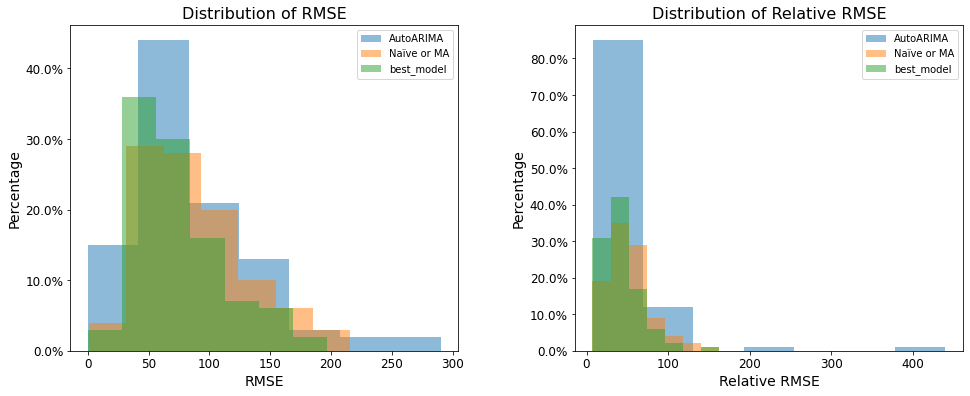

In [89]:
# Plot Errors distributions by test

# Set the figure size
plt.figure(figsize=(16, 6))

# Group the data by 'test_name'
grouped_data = product_results_df.groupby('test_name')

# Create a subplot grid with 1 row and 2 columns
grid = plt.GridSpec(1, 2, width_ratios=[1, 1])

# Plot histograms for 'RMSE' and 'Relative RMSE'
for i, metric in enumerate(['RMSE', 'Relative RMSE']):
    ax = plt.subplot(grid[0, i])

    # Iterate over each 'test_name' group
    for test_name, group_data in grouped_data:
        # Filter out missing values in the column
        numeric_data = pd.to_numeric(group_data[metric], errors='coerce')
        numeric_data = numeric_data.dropna()

        # Plot the histogram for the current 'test_name' group
        counts, bins, _ = plt.hist(numeric_data, bins=7, alpha=0.5, label=test_name)

    # Calculate the total number of data points
    total_data_points = len(product_results_df)

    # Set the labels and title
    plt.xlabel(metric, fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.title('Distribution of ' + metric, fontsize=16)

    # Set the y-axis tick labels as percentages
    plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()])

    # Increase the size of the tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add a legend
    plt.legend()

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.3)

# Display the plot
plt.show()


In [92]:
# Save results tables
to_save = [results_df ,updated_results_df, global_results_df, product_results_df,best_model]
file_names = ['results_df.csv', 'updated_results_df.csv', 'global_results_df.csv', 'product_results_df.csv','best_model.csv']

save_path = path + '/backtesting_results/'

for data, file_name in zip(to_save, file_names):
    file_path = save_path + file_name
    data.to_csv(file_path, index=False)

print("Datasets saved successfully!")

Datasets saved successfully!


#### <font color='313187'>Backtesting Plots<font><a class='anchor' id='backtestingPlots'></a> [↑](#top)

In [6]:
# Retrieve data and check we don't have any duplicates
updated_results_df=pd.read_csv(path + '/backtesting_results/updated_results_df.csv')

In [7]:
# Select the test you want to plot
test_names = updated_results_df['test_name'].unique()
print('Select a test to plot: ' + test_names)

['Select a test to plot: Naïve or MA' 'Select a test to plot: AutoARIMA'
 'Select a test to plot: best_model']


In [8]:
# Print test name to print
test_name = test_names[2]
print('Plotting test: ' + str(test_name))
print()

plot_data = updated_results_df[updated_results_df['test_name'] == test_name]
plot_data.shape[0]

Plotting test: best_model



1300

In [11]:
plot_data.head(20)

,product_number,model_name,is_seasonal,outliers_treatment,validation_approach,actuals,prediction,test_name
2600,9870,Naïve or MA,False,0,rolling,121.0,131.615385,best_model
2601,9870,Naïve or MA,False,0,rolling,113.5,132.662722,best_model
2602,9870,Naïve or MA,False,0,rolling,134.0,131.098316,best_model
2603,9870,Naïve or MA,False,0,rolling,68.0,127.567417,best_model
2604,9870,Naïve or MA,False,0,rolling,45.0,130.226449,best_model
2605,9870,Naïve or MA,False,0,rolling,50.0,135.243868,best_model
2606,9870,Naïve or MA,False,0,rolling,66.0,139.570320,best_model
2607,9870,Naïve or MA,False,0,rolling,124.0,139.768037,best_model
2608,9870,Naïve or MA,False,0,rolling,144.0,142.211732,best_model
2609,9870,Naïve or MA,False,0,rolling,190.0,142.074173,best_model


Plotting model: best_model

Number of files to plot: 17
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/forecast_validation_best_model_file_0.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/forecast_validation_best_model_file_1.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/forecast_validation_best_model_file_2.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/forecast_validation_best_model_file_3.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/forecast_validation_best_model_file_4.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/forecast_validation_best_model_file_5.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/forecast_validation_best_mo

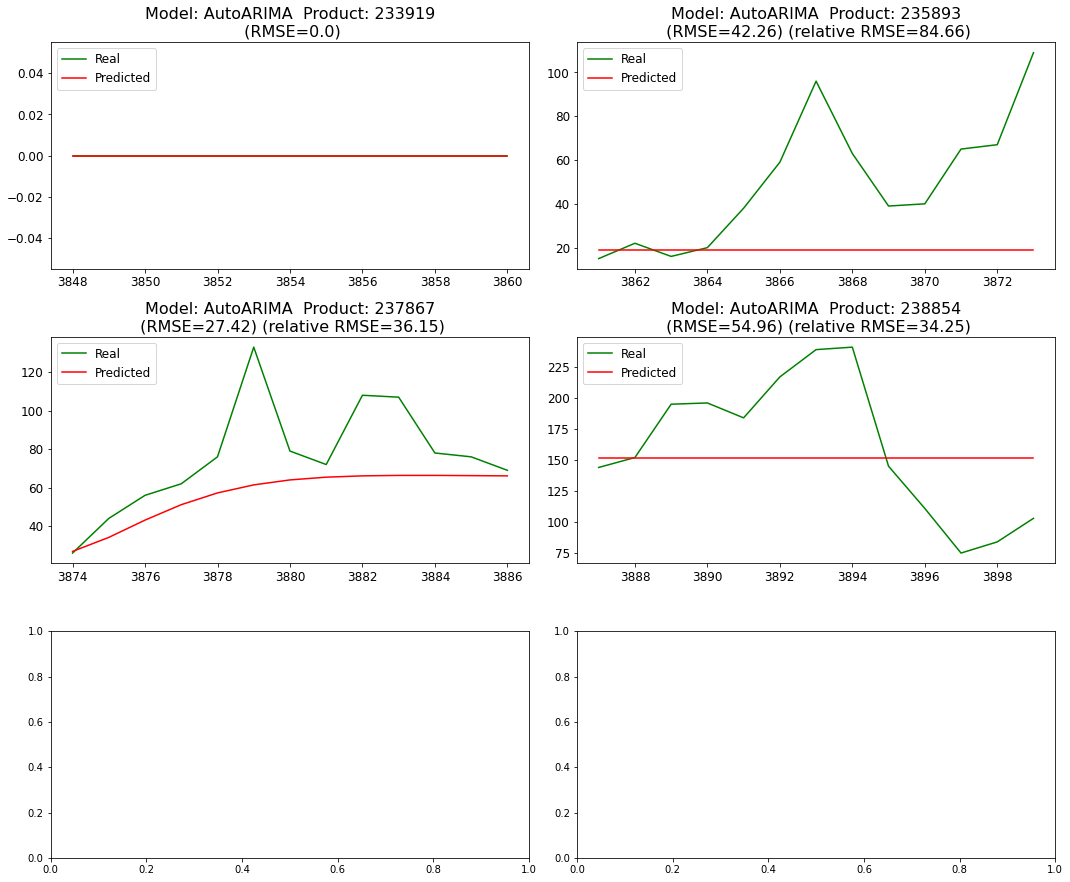

In [17]:
### Create prediction plots with it's test values 

# Print test name
print('Plotting model: ' + str(test_name))
print()

subplotindex=0
numcols=2
numrows = 3

# Create a figure
fig = plt.figure() # So we can close it at the beginning and then be able to plot the last page in the notebook

# Calculate the number of subplots per page
subplots_per_file = numrows * numcols


# Set the number of subplots per PDF file
num_products = plot_data['product_number'].drop_duplicates().shape[0]


# Calculate the number of PDF files required
num_files = math.ceil(num_products / subplots_per_file)
print('Number of files to plot: ' + str(num_files))

# Iterate over the number of PDF files
for file_index in range(num_files):

    # Close the current figure
    plt.close(fig)
    plt.close('all')

    pdf_file = '/plots/forecast_validation_' + test_name + '_file_'+ str(file_index) + '.pdf'
    pdf_path = path + pdf_file

    start_index = file_index * subplots_per_file*TEST_SIZE
    end_index = (file_index + 1) * subplots_per_file*TEST_SIZE


    # Get the corresponding subset of product_reporters
    plot_data_subset = plot_data[start_index:end_index]


    fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)

    # Iterate over the subplots on the current page
    for subplot_index, (product_number, product_data) in enumerate(plot_data_subset.groupby('product_number')):
        if subplot_index >= subplots_per_file:
            break  # Stop plotting if we exceed the subplots_per_file limit

   
        # Get model for the current product
        model_name = product_data['model_name'].unique()[0]
        
        rowindex = subplot_index // numcols
        colindex = subplot_index % numcols

        test = product_data['actuals']
        predictions = product_data['prediction']

        # Calculate the RMSE for the product
        rmse = np.sqrt(mean_squared_error(test, predictions))
        mean_act = round(np.mean(test),2)
        
        # Calculate the RMSE for the product
     
        if mean_act == 0:
            # Handle the case where the mean of actuals is zero
            relative_rmse = 'N/A'  # or assign a default value
        else:
            relative_rmse = round((rmse / mean_act) * 100, 2)


        # Set the subplot title
        if relative_rmse == 'N/A':
            title = 'Model: ' + model_name + '  Product: ' + str(product_number) + '\n (RMSE=' + str(round(rmse, 2)) + ')'
        else:
            title = 'Model: ' + model_name + '  Product: ' + str(product_number) + '\n (RMSE=' + str(round(rmse, 2)) + ')' \
                    + ' (relative RMSE=' + str(round(float(relative_rmse), 2)) + ')'

        ax[rowindex, colindex].plot(test, color='green', label='Test')
        ax[rowindex, colindex].plot(predictions, color='red')     
        ax[rowindex, colindex].set_title(title, fontsize=16)
        legend = ax[rowindex, colindex].legend(['Real', 'Predicted'], loc='upper left', fontsize=12, markerfirst=True)
        legend.legendHandles[1]._sizes = 90  # Increase the size of the second legend marker (square)
        subplotindex=subplotindex+1

        # Increase the size of the tick labels
        ax[rowindex, colindex].tick_params(axis='x', labelsize=12)
        ax[rowindex, colindex].tick_params(axis='y', labelsize=12)

    # Save the plots to a PDF file
    with PdfPages(pdf_path) as pdf:
        pdf.savefig(fig)

    print(f"Plots saved to {pdf_path}")

    # Pause the execution for 3 seconds
    time.sleep(3)   
    
    #plt.show() 

Plotting model: best_model

Number of files to plot: 17
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/forecast_validation_hist_best_model_file_0.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/forecast_validation_hist_best_model_file_1.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/forecast_validation_hist_best_model_file_2.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/forecast_validation_hist_best_model_file_3.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/forecast_validation_hist_best_model_file_4.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/forecast_validation_hist_best_model_file_5.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plo

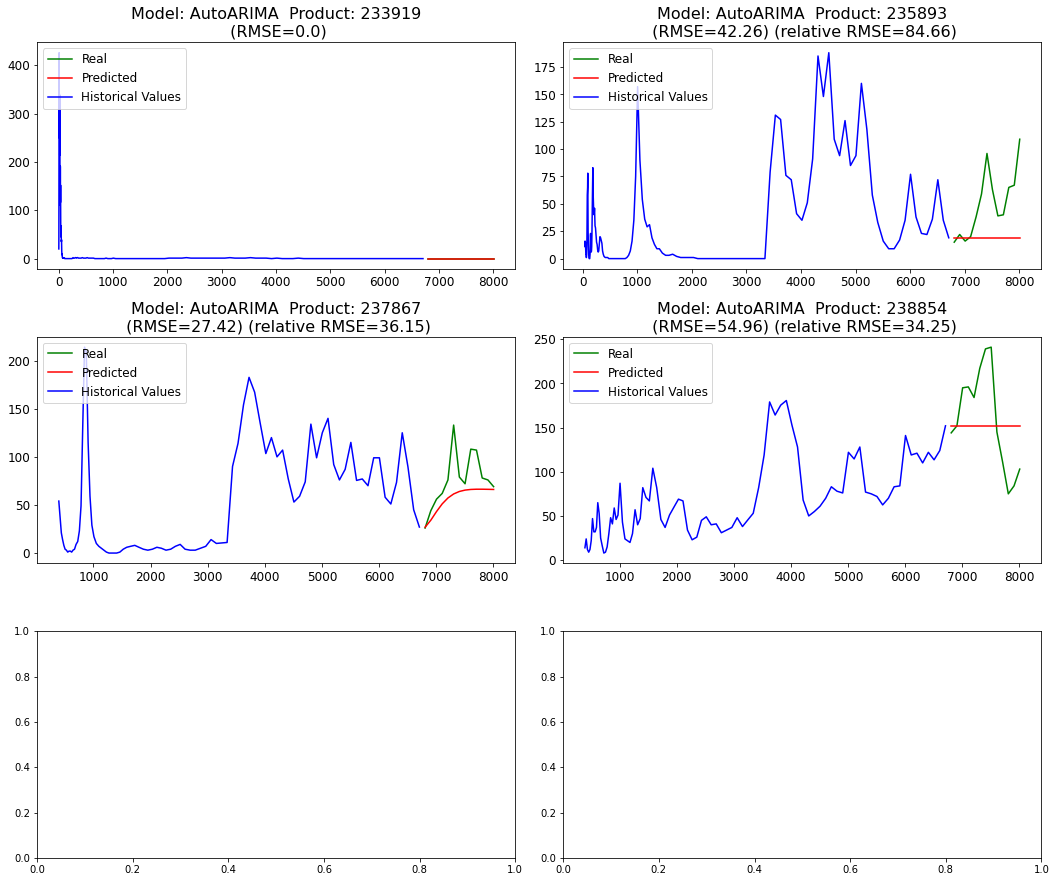

In [20]:
### Create prediction plots with history

# Get model to create the plots for
print('Plotting model: ' + str(test_name))
print()

subplotindex=0
numcols=2
numrows = 3

# Calculate the number of subplots per page
subplots_per_file = numrows * numcols


# Set the number of subplots per PDF file
num_products = plot_data['product_number'].drop_duplicates().shape[0]

# Calculate the number of PDF files required
num_files = math.ceil(num_products / subplots_per_file)
print('Number of files to plot: ' + str(num_files))


# Iterate over the number of PDF files
for file_index in range(num_files):

    # Close the current figure
    plt.close(fig)
    plt.close('all')

    pdf_file = '/plots/forecast_validation_hist_' + test_name + '_file_'+ str(file_index) + '.pdf'
    pdf_path = path + pdf_file
 
    start_index = file_index * subplots_per_file*TEST_SIZE
    end_index = (file_index + 1) * subplots_per_file*TEST_SIZE

    # Get the corresponding subset of product_reporters
    plot_data_subset = plot_data[start_index:end_index]

    fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    
    # Iterate over the subplots on the current page
    for subplot_index, (product_number, product_data) in enumerate(plot_data_subset.groupby('product_number')):
        if subplot_index >= subplots_per_file:
            break  # Stop plotting if we exceed the subplots_per_file limit

        # Get model for the current product
        model_name = product_data['model_name'].unique()[0]
        
        rowindex = subplot_index // numcols
        colindex = subplot_index % numcols


        # Test and predictions
        test = product_data['actuals']
        predictions = product_data['prediction']

        # Retrieve historical data for the current product
        historical_data = df[df['product_number'] == product_number]['inventory_units_imputed_missing']

        # Split the historical data into train and test sets
        size = len(historical_data) - TEST_SIZE
        train, test = historical_data[:size], historical_data[size:]

        # Assign the index of the test data to the predictions
        predictions.index = test.index
        
        # Calculate the RMSE and relative RMSE for the product
        rmse = np.sqrt(mean_squared_error(test, predictions))
        mean_act = round(np.mean(test),2)
        if mean_act == 0:
            # Handle the case where the mean of actuals is zero
            relative_rmse = 'N/A'  # or assign a default value
        else:
            relative_rmse = round((rmse / mean_act) * 100, 2)
    
        # Set the subplot title
        if relative_rmse == 'N/A':
            title = 'Model: ' + model_name + '  Product: ' + str(product_number) + '\n (RMSE=' + str(round(rmse, 2)) + ')'
        else:
            title = 'Model: ' + model_name + '  Product: ' + str(product_number) + '\n (RMSE=' + str(round(rmse, 2)) + ')' \
                    + ' (relative RMSE=' + str(round(float(relative_rmse), 2)) + ')'

        # Plot the historical data
        ax[rowindex, colindex].plot(test, color='green', label='Test')
        ax[rowindex, colindex].plot(predictions, color='red')
        ax[rowindex, colindex].plot(train, color='blue', label='Historical')
        ax[rowindex,colindex].set_title(title, fontsize=16)
        legend = ax[rowindex, colindex].legend(['Real', 'Predicted', 'Historical Values'], loc='upper left', fontsize=12, markerfirst=True)
        legend.legendHandles[1]._sizes = 90  # Increase the size of the second legend marker (square)
        subplotindex=subplotindex+1
        
        # Increase the size of the tick labels
        ax[rowindex, colindex].tick_params(axis='x', labelsize=12)
        ax[rowindex, colindex].tick_params(axis='y', labelsize=12)

    # Save the plots to a PDF file
    with PdfPages(pdf_path) as pdf:
        pdf.savefig(fig)

    print(f"Plots saved to {pdf_path}")

    # Pause the execution for 3 seconds
    time.sleep(3)   
    
    #plt.show() 

### <font color='313187'>Get future forecast<font><a class='anchor' id='futureForecast'></a> [↑](#top)

TODO: update seasonal/no-seasonal cluster with train + test data

In [21]:
# Retrieve data and check we don't have any duplicates
df=pd.read_csv(path + '/data/processed/aggregated_board.csv')
duplicates = df.duplicated(subset=['date','product_number'])
duplicate_rows = df[duplicates]
print('Number of duplicates: ' + str(duplicate_rows.shape[0]))

Number of duplicates: 0


In [102]:
# Initialize actual future results list
future_results_list = []

# Sort the year_week column and drop duplicate values
sorted_year_week = test_df['year_week'].drop_duplicates().sort_values().reset_index(drop=True)

# Select test size
TEST_SIZE = len(sorted_year_week)

# Display the sorted year_week values
print('First week to forecast: ' + sorted_year_week[0])
print('Last week to forecast: ' + sorted_year_week[12])
print()
print(sorted_year_week)

First week to forecast: 202319
Last week to forecast: 202331

0     202319
1     202320
2     202321
3     202322
4     202323
5     202324
6     202325
7     202326
8     202327
9     202328
10    202329
11    202330
12    202331
Name: year_week, dtype: object


#### <font color='313187'>Future forecast with Seasonal Naïve and MA models<font><a class='anchor' id='futureFcstNaiveMA'></a> [↑](#top)

In [ ]:
### Future forecast with Seasonal Naïve and MA
forcast_evolution = 1
total_num_prod = df['product_number'].drop_duplicates().shape[0]

# Iterate for each product
for product_number, product_data in df.groupby('product_number'):
    print('Forecasting product: ' + str(product_number) + '  '+ str(forcast_evolution) +'/'+str(total_num_prod))
    X = product_data['inventory_units_imputed_missing']
    train = X  # Use all data for training
    history = list(train)
    predictions = []

    is_seasonal = product_data['is_seasonal'].iloc[0]
    
    # Iterate for each week (rolling approach)
    for t in range(TEST_SIZE):
        if is_seasonal:
            last_year_week_index = -52

            if -last_year_week_index > len(train):
                # If there are no previous year observations available, apply MA
                window_size = TEST_SIZE  # Number of previous observations to include in the average
                y = np.mean(history[-window_size:])
            else:
                y = history[last_year_week_index]  # Use the previous year's observation for the same week
     
        else:
            window_size = TEST_SIZE  # Number of previous observations to include in the average
            y = np.mean(history[-window_size:])
        
        # Append predictions to predictions list and train set (history)
        predictions.append(y)
        history.append(y)
 
    forcast_evolution += 1
    
    # Prepare results table using pandas DataFrame
    product_results_df = pd.DataFrame({'product_number': product_number,
                                       'year_week': sorted_year_week,
                                       'model_name': 'Naïve or MA',
                                       'prediction': predictions})
    
    # Append the results for the current product to the overall results list
    future_results_list.append(product_results_df)

print('Forecast has finished')


#### <font color='313187'>Future forecast with AutoArima<font><a class='anchor' id='futureFctsAutoarimia'></a> [↑](#top)

In [ ]:
### Future forecast with AutoArima

# Some products don't work in the future with arima model so we will use Naïve/MA approach instead
#TODO: find why and fix it
not_working_in_arima = [43428, 51324, 230958, 45402]
df = df[~df['product_number'].isin(not_working_in_arima)]


forcast_evolution = 1
total_num_prod = df['product_number'].drop_duplicates().shape[0]

# Iterate for each product
for product_number, product_data in df.groupby('product_number'):
    print('Forecasting product: ' + str(product_number) + '  '+ str(forcast_evolution) +'/'+str(total_num_prod))
    X = product_data['inventory_units_imputed_missing']
    size = len(X)  # Use all data for training
    history = [c for c in X]
    predictions = []
    
    # Iterate for each week (rolling approach)
    for t in range(TEST_SIZE):
        if product_data['is_seasonal'].iloc[0]:
            model = auto_arima(X, 
                               start_p=1, start_q=1,
                               max_p=5, max_q=5, 
                               m=52, #52 for weekly data, 12 for monthly data
                               max_d=1, max_D=1,
                               start_P=0, start_Q=0, 
                               max_P=5, max_Q=5, 
                               seasonal=True,
                               trace=False,
                               error_action='ignore',
                               suppress_warnings=True, 
                               stepwise=True) # True to speed up the parameter selection
            is_seasonal = True
        else:
            model = auto_arima(X, start_p=1, start_q=1,
                               max_p=5, max_q=5, max_d=1,
                               trace=False, seasonal=False,
                               error_action='ignore',
                               suppress_warnings=True, 
                               stepwise=True) 
            is_seasonal = False
        
        # Fit the model and get forecast
        model_fit = model.fit(history)
        output = model_fit.predict(n_periods=1)
        yhat = output[0]
        
        # Append predictions to predictions list and train set (history)
        predictions.append(yhat)
        history.append(yhat)
    
    forcast_evolution += 1
    
    # Prepare results table using pandas DataFrame
    product_results_df = pd.DataFrame({'product_number': product_number,
                                       'year_week': sorted_year_week,
                                       'model_name': 'AutoARIMA',
                                       'prediction': predictions})
    
    # Append the results for the current product to the overall results list
    future_results_list.append(product_results_df)

    
print('Forecast has finished')

In [147]:
# Save results (autoarima was running slow)
individual_models_future_results_df = pd.concat(future_results_list, ignore_index=True)

save_path = path + '/future_results/'
file_name = 'individual_models_future_results.csv'
file_path = save_path + file_name
individual_models_future_results_df.to_csv(file_path, index=False)

#### <font color='313187'>Future forecast with Best Model<font><a class='anchor' id='futureFctsBestModel'></a> [↑](#top)

In [ ]:
# Some products don't work in the future with arima model so we will use Naïve/MA approach instead
best_model_fix = copy.copy(best_model)

best_model_fix.loc[best_model_fix['product_number'].isin(not_working_in_arima), 'model_name'] = 'Naïve or MA'
best_model_fix[best_model_fix['product_number'].isin(not_working_in_arima)]


In [332]:
# Convert results list to DataFrame
individual_models_future_results_df = pd.concat(future_results_list, ignore_index=True)
individual_models_future_results_df['test_name'] = individual_models_future_results_df['model_name']

# Subset resulst_df table by best model
best_model_future_results_df = pd.merge(individual_models_future_results_df, 
                                        best_model_fix[['product_number', 'model_name']], 
                                        on=['product_number', 'model_name'], 
                                        how='inner')
best_model_future_results_df['test_name'] = 'best_model'
print(best_model_future_results_df.shape[0])

# Concatenate the selected_rows DataFrame with the original results_df DataFrame
all_future_forecast_tests = pd.concat([individual_models_future_results_df, best_model_future_results_df], ignore_index=True)


# Prepare final submission (best_model test)
final_submission = copy.copy(best_model_future_results_df)
final_submission.rename(columns={'prediction': 'inventory_units'}, inplace=True)
final_submission['id'] = final_submission['year_week'].astype(str) + '-' + final_submission['product_number'].astype(str)
columns = ['id','inventory_units']
final_submission = final_submission[columns]
print(final_submission.shape[0])
final_submission.head()

1300
1300


,id,inventory_units
0,202319-7896,110.0
1,202320-7896,110.0
2,202321-7896,110.0
3,202322-7896,110.0
4,202323-7896,110.0


In [334]:
### Check final submission has all dates and products
# Get the IDs from test_df
test_ids = set(test_df['id'])

# Get the IDs from final_submission
submission_ids = set(final_submission['id'])

# Check if the sets of IDs are equal
if test_ids == submission_ids:
    print("The IDs in test_df and final_submission are exactly the same.")
else:
    print("There are discrepancies between the IDs in test_df and final_submission.")

    # Find the differing IDs
    differing_ids = list(test_ids.symmetric_difference(submission_ids))

    # Drop duplicates from the differing IDs list
    differing_ids = list(set(differing_ids))

    # Print the differing IDs
    print("Differing IDs:")
    for id in differing_ids:
        print(id)

The IDs in test_df and final_submission are exactly the same.


In [336]:
# Save future results tables
to_save = [final_submission,
           all_future_forecast_tests,
           individual_models_future_results_df,
           best_model_future_results_df]
file_names = ['final_submission.csv',
              'all_future_forecast_tests.csv',
              'individual_models_future_results_df.csv',
              'best_model_future_results_df.csv']

save_path = path + '/future_results/'

for data, file_name in zip(to_save, file_names):
    file_path = save_path + file_name
    data.to_csv(file_path, index=False)

print("Datasets saved successfully!")

Datasets saved successfully!


#### <font color='313187'>Future forecast plots<font><a class='anchor' id='futureFctsPlots'></a> [↑](#top)

In [110]:
# Retrieve data and check we don't have any duplicates
df=pd.read_csv(path + '/data/processed/aggregated_board.csv')
duplicates = df.duplicated(subset=['date','product_number'])
duplicate_rows = df[duplicates]
print('Number of duplicates: ' + str(duplicate_rows.shape[0]))

Number of duplicates: 0


In [22]:
# Retrieve results from local
all_future_forecast_tests=pd.read_csv(path + '/future_results/all_future_forecast_tests.csv')

In [23]:
# Select the test you want to plot
test_names = all_future_forecast_tests['test_name'].unique()
print('Select a test to plot: ' + test_names)

['Select a test to plot: AutoARIMA' 'Select a test to plot: Naïve or MA'
 'Select a test to plot: best_model']


In [24]:
# Print test name
test_name = test_names[2]
print('Plotting test: ' + str(test_name))
print()

plot_data = all_future_forecast_tests[all_future_forecast_tests['test_name'] == test_name]
plot_data.shape[0]

Plotting test: best_model



1300

Plotting model: best_model

Number of files to plot: 17
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/future_forecast_best_model_file_0.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/future_forecast_best_model_file_1.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/future_forecast_best_model_file_2.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/future_forecast_best_model_file_3.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/future_forecast_best_model_file_4.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/future_forecast_best_model_file_5.pdf
Plots saved to C:/Users/Laura/OneDrive/Documentos/LAURA/KNOWLEDGE/CODIS/Business Case/HP/plots/future_forecast_best_model_file_6.pdf
Plots saved t

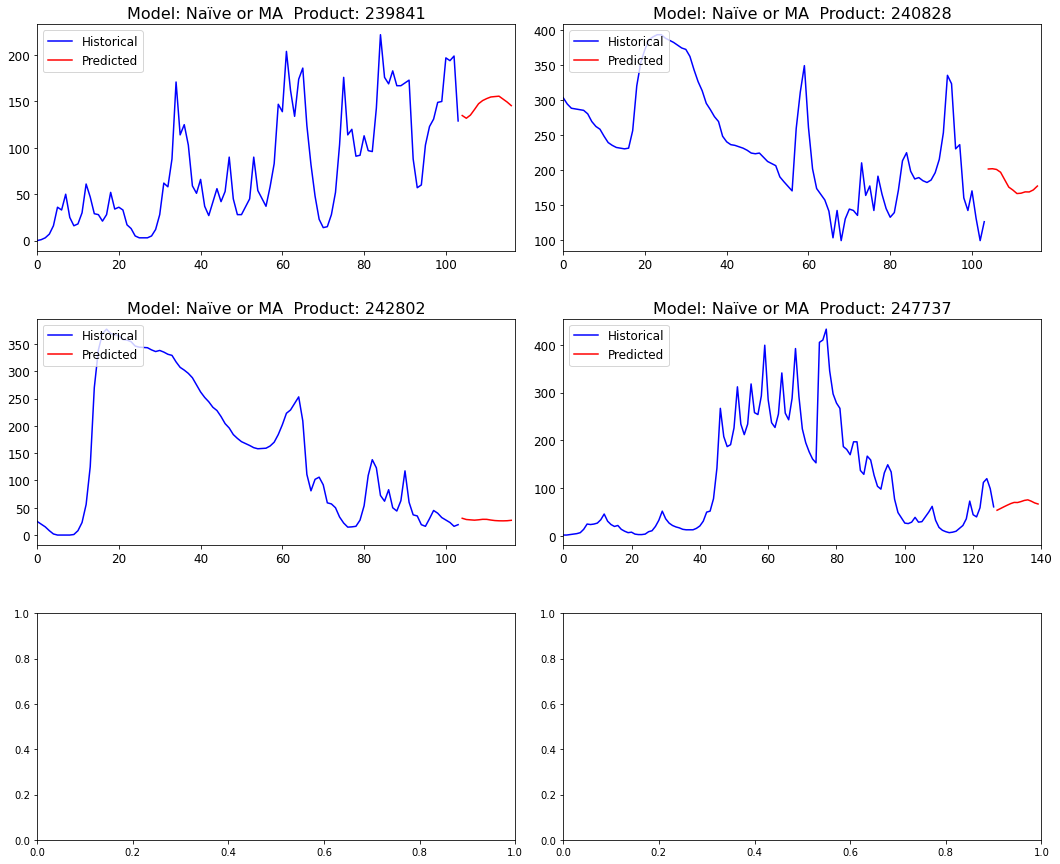

In [25]:
# Create future prediction plots with history

# Get model to create the plots for
print('Plotting model: ' + str(test_name))
print()

numcols = 2
numrows = 3

# Calculate the number of subplots per page
subplots_per_file = numrows * numcols

# Set the number of subplots per PDF file
num_products = plot_data['product_number'].nunique()

# Calculate the number of PDF files required
num_files = math.ceil(num_products / subplots_per_file)
print('Number of files to plot: ' + str(num_files))

# Iterate over the number of PDF files
for file_index in range(num_files):

    # Close the current figure
    plt.close(fig)
    plt.close('all')

    pdf_file = '/plots/future_forecast_' + test_name + '_file_' + str(file_index) + '.pdf'
    pdf_path = path + pdf_file

    start_index = file_index * subplots_per_file*TEST_SIZE
    end_index = (file_index + 1) * subplots_per_file*TEST_SIZE
    
    # Get the corresponding subset of product_reporters
    plot_data_subset = plot_data[start_index:end_index]
    
    fig, ax = plt.subplots(numrows, numcols, figsize=(18, 15))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)

    # Iterate over the subplots on the current page
    for subplot_index, (product_number, product_data) in enumerate(plot_data_subset.groupby('product_number')):
        if subplot_index >= subplots_per_file:
            break  # Stop plotting if we exceed the subplots_per_file limit

        # Get model for the current product
        model_name = product_data['model_name'].unique()[0]

        rowindex = subplot_index // numcols
        colindex = subplot_index % numcols

        # Retrieve historical data for the current product
        historical_data = df[df['product_number'] == product_number]['inventory_units_imputed_missing']
        history_length = len(historical_data)

        # Assign the index of the test data to the predictions
        predictions = product_data['prediction']
        prediction_length = len(predictions)
        prediction_start_index = 0
        prediction_end_index = prediction_length

        # Set the x-axis limits
        ax[rowindex, colindex].set_xlim(0, history_length + prediction_length)

        # Plot the historical data
        ax[rowindex, colindex].plot(range(history_length), historical_data, color='blue', label='Historical')
        ax[rowindex, colindex].plot(range(history_length, history_length + prediction_length), predictions,
                                    color='red', label='Predicted')
        ax[rowindex, colindex].set_title('Model: ' + model_name + '  Product: ' + str(product_number), fontsize=16)
        legend = ax[rowindex, colindex].legend(loc='upper left', fontsize=12, markerfirst=True)
        legend.legendHandles[0]._sizes = 90  # Increase the size of the first legend marker (square)
        legend.legendHandles[1]._sizes = 90  # Increase the size of the second legend marker (square)

        # Increase the size of the tick labels
        ax[rowindex, colindex].tick_params(axis='x', labelsize=12)
        ax[rowindex, colindex].tick_params(axis='y', labelsize=12)

    # Save the plots to a PDF file
    with PdfPages(pdf_path) as pdf:
        pdf.savefig(fig)

    print(f"Plots saved to {pdf_path}")

    # Pause the execution for 3 seconds
    time.sleep(3)


### <font color='313187'>Kaggle Score for best model<font><a class='anchor' id='kaggle'></a> [↑](#top)

- Score: 116.51040
- Public score: 125.52941

### <font color='313187'>Future work<font><a class='anchor' id='futureWork'></a> [↑](#top)

- Missing values:
    - Enhance the understanding of missing values by engaging in discussions with the business stakeholders.
    - Improve missing values imputation techniques, such as utilizing the last observed value for products or reporters with a high number of missing values.
- Outlier detection and imputation:
    - Detect outliers and handle them by incorporating business knowledge or employing statistical methods.
- Backtesting:
    - Increase the number of backtesting windows to evaluate the model's performance across different time periods.
- Model exploration:
    - Explore alternative models to potentially improve predictive accuracy.
    - Experiment with ensemble models, which combine the predictions of multiple models to obtain a more robust and accurate result.
- Incorporating external variables:
    - Consider utilizing external variables, which can provide additional information and potentially enhance the predictive power of the model.